In [1]:
import os
import torchvision

from torch import cuda, device, Tensor, save, load, stack, zeros, vstack, squeeze
from src.plots import plot_vae_training_result, plot_image, plot_image_label_two
from src.vae.mnist_vae import ConditionalVae
from src.image_classifier.image_classifier import MNISTClassifier
from src.image_classifier.exq_net_v1 import ExquisiteNetV1

from src.utils import frechet_inception_distance
from src.sampling import split_dirichlet

device = device('cuda' if cuda.is_available() else 'cpu')

In [2]:
num_data = 60000

training_data = torchvision.datasets.MNIST(root='../../data/MNIST_train', train=True, download=True, transform=torchvision.transforms.ToTensor())
testing_data = torchvision.datasets.MNIST(root='../../data/MNIST_test', train=False, download=True, transform=torchvision.transforms.ToTensor())

input = training_data.data[:num_data]
labels = training_data.targets[:num_data]

In [3]:
# parameters
model = "cvae"
dataset = "mnist"
batch_size = 64
epoch = 10
learning_rate = 0.01

model_path = f"../../models/{model}_{dataset}_{batch_size}_{epoch}_{learning_rate}.pt"

if os.path.exists(model_path):
    vae = load(model_path)
else:
    vae = ConditionalVae(dim_encoding=3).to(device)

    vae_model, vae_loss_li, kl_loss_li = vae.train_model(
        training_data=training_data,
        batch_size=batch_size,
        epochs=epoch,
        learning_rate=learning_rate
    )
    save(vae, model_path)
    
    # move tensors to cpu before converting to np array
    np_kl_loss_li = []
    
    for output in kl_loss_li:
        if isinstance(output, Tensor):
            np_kl_loss_li.append(output.cpu().detach().numpy())
    
    # plot results
    plot_vae_training_result(
        input=input,
        labels=labels,
        vae_model=vae_model,
        vae_loss_li=vae_loss_li,
        kl_loss_li=np_kl_loss_li
    )

In [76]:
training_data.data = training_data.data / 255.0
print(training_data.data[:1000].mean().item())
print(training_data.data[1])

0.1282389611005783
tensor([[0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0

In [4]:
# for i in range(10):

images = vae.generate_data(n_samples=5, target_label=0)
print(images.shape)
# plot_image(images)
# 
# print(vae.generate_data(n_samples=1000, target_label=0).mean().item() * 0.75)
# print(vae.generate_data(n_samples=1, target_label=1))


torch.Size([5, 1, 28, 28])


In [3]:
# simple classifier for performance evaluation
model = "classifier"
dataset = "mnist"
batch_size = 64
epoch = 10

classifier_path = f"../../models/{model}_{dataset}_{batch_size}_{epoch}.pt"

# if os.path.exists(classifier_path):
#     classifier = load(classifier_path)
# else:
classifier = MNISTClassifier(input_size=784, num_classes=10)
classifier.train_model(training_data, batch_size=batch_size, epochs=epoch)
accuracy = classifier.test_model(testing_data)
print("Test accuracy: ", accuracy)
save(classifier, classifier_path)

Epoch done:  1
Epoch done:  2
Epoch done:  3
Epoch done:  4
Epoch done:  5
Epoch done:  6
Epoch done:  7
Epoch done:  8
Epoch done:  9
Epoch done:  10
6217
3783
Test accuracy:  0.6217


In [5]:
# CNN classifier for performance evaluation
model = "classifier"
dataset = "mnist"
batch_size = 64
learning_rate = 0.01
epoch = 10

classifier = ExquisiteNetV1(class_num=10, img_channels=1)

classifier.to(device)
classifier.train_model(training_data, testing_data, batch_size=batch_size, learning_rate=learning_rate, epochs=epoch)
accuracy, loss, f1_macro, f1_micro = classifier.test_inference(testing_data, batch_size=batch_size)
print(accuracy, loss, f1_macro, f1_micro)

/home/neo/projects/Federated-Learning-PyTorch/venv/lib/python3.12/site-packages/torch/nn/modules/conv.py:456: UserWarning: Plan failed with a cudnnException: CUDNN_BACKEND_EXECUTION_PLAN_DESCRIPTOR: cudnnFinalize Descriptor Failed cudnn_status: CUDNN_STATUS_NOT_SUPPORTED (Triggered internally at ../aten/src/ATen/native/cudnn/Conv_v8.cpp:919.)
  return F.conv2d(input, weight, bias, self.stride,
/home/neo/projects/Federated-Learning-PyTorch/venv/lib/python3.12/site-packages/torch/autograd/graph.py:744: UserWarning: Plan failed with a cudnnException: CUDNN_BACKEND_EXECUTION_PLAN_DESCRIPTOR: cudnnFinalize Descriptor Failed cudnn_status: CUDNN_STATUS_NOT_SUPPORTED (Triggered internally at ../aten/src/ATen/native/cudnn/Conv_v8.cpp:919.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


Epoch done:  1
Training loss:  0.7095406651496887
Testing loss:  -5.4622869461205354
Epoch done:  2
Training loss:  0.2347443401813507
Testing loss:  -7.178951375803371


In [6]:
# generate data for testing on classifier
# this one stays the same
data_count = 10000
ratios = [0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1]
images = []
labels = []

for label_idx, ratio in enumerate(ratios):
    num_samples_to_generate = int(data_count * ratio)
    images.append(vae.generate_data(n_samples=num_samples_to_generate, target_label=label_idx).cpu().detach())
    
    label = zeros((num_samples_to_generate, 10), device=device)
    label[:, label_idx] = 1
    labels.append(label.cpu().detach())

final_images = vstack(images)
final_labels = vstack(labels)

assert final_images.shape[0] == final_labels.shape[0]

accuracy = classifier.test_model_syn_img_label(final_images, final_labels)
print("Accuracy: ", accuracy)

Accuracy:  0.9993


In [6]:
# Determine FID
# generate 500 images
# normalizing necessary to make pixels in [0, 1] range for FID

testing_data = torchvision.datasets.MNIST(root='../../data/MNIST_test', train=False, download=True, transform=torchvision.transforms.ToTensor())

num_data = 400

input = testing_data.data[:num_data] / 255.0
syn_input = vae.generate_data(n_samples=num_data)

input_rgb = input.view(-1, 1, 28, 28).repeat(1, 3, 1, 1)
syn_input_rgb = syn_input.view(-1, 1, 28, 28).repeat(1, 3, 1, 1)

# compute FID score
fid_score = frechet_inception_distance(input_rgb, syn_input_rgb)
print("Frechet Inception Distance: ", fid_score)

NameError: name 'vae' is not defined

In [7]:
# test baseline as IID data
num_users = [3, 5, 10]
for num_user in num_users:
    model_state_dict_path = f"../../models/federated_cvae_mnist_1_1.0_20_2_{num_user}.pt"
    loaded_state_dict = load(model_state_dict_path)
    global_model = ConditionalVae(dim_encoding=3)
    global_model.load_state_dict(loaded_state_dict)
        
    data_count = 10000
    ratios = [0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1]
    images = []
    labels = []
    
    for label_idx, ratio in enumerate(ratios):
        num_samples_to_generate = int(data_count * ratio)
        images.append(global_model.generate_data(n_samples=num_samples_to_generate, target_label=label_idx).cpu().detach())
        
        label = zeros((num_samples_to_generate, 10), device=device)
        label[:, label_idx] = 1
        labels.append(label.cpu().detach())
    
    final_images = vstack(images)
    final_labels = vstack(labels)
    
    assert final_images.shape[0] == final_labels.shape[0]
    
    accuracy = classifier.test_model_syn_img_label(final_images, final_labels)
    print(f"IID data num users {num_user} accuracy: ", accuracy)

IID data num users 3 accuracy:  0.9395
IID data num users 5 accuracy:  0.8861
IID data num users 10 accuracy:  0.8228


Num user 3, Dirichlet beta 0.1 accuracy:  0.9366
Num user 3, Dirichlet beta 0.2 accuracy:  0.9844
Num user 3, Dirichlet beta 0.3 accuracy:  0.9683
Num user 3, Dirichlet beta 0.4 accuracy:  0.933
Num user 3, Dirichlet beta 0.5 accuracy:  0.9814
Num user 3, Dirichlet beta 0.6 accuracy:  0.9654
Num user 3, Dirichlet beta 0.7 accuracy:  0.9137
Num user 3, Dirichlet beta 0.8 accuracy:  0.9597
Num user 3, Dirichlet beta 0.9 accuracy:  0.9658
Num user 3, Dirichlet beta 1.0 accuracy:  0.9487
Num user 5, Dirichlet beta 0.1 accuracy:  0.9118
Num user 5, Dirichlet beta 0.2 accuracy:  0.8907
Num user 5, Dirichlet beta 0.3 accuracy:  0.9643
Num user 5, Dirichlet beta 0.4 accuracy:  0.9495
Num user 5, Dirichlet beta 0.5 accuracy:  0.9207
Num user 5, Dirichlet beta 0.6 accuracy:  0.9615
Num user 5, Dirichlet beta 0.7 accuracy:  0.9265
Num user 5, Dirichlet beta 0.8 accuracy:  0.8962
Num user 5, Dirichlet beta 0.9 accuracy:  0.9675
Num user 5, Dirichlet beta 1.0 accuracy:  0.9129
Num user 10, Dirichle

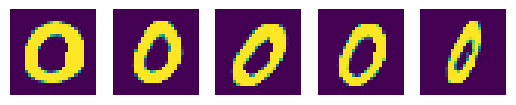

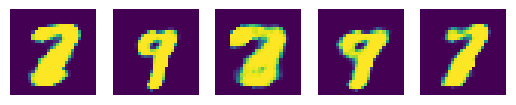

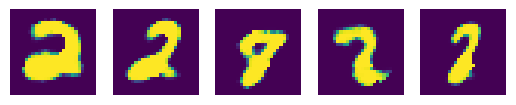

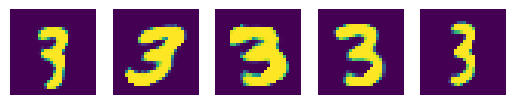

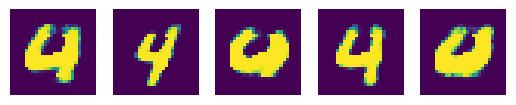

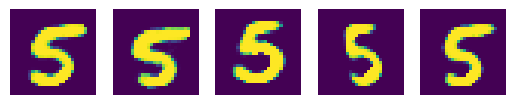

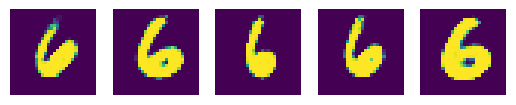

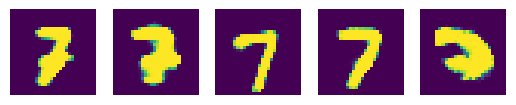

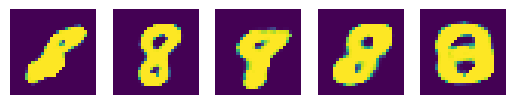

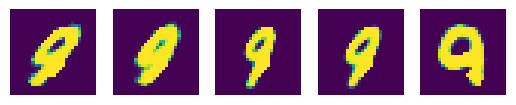

In [8]:
# test on no-IID data
# test the federated global model against the classifier over multiple dirichlet and communication rounds
#     torch.save(global_model.state_dict(), f"/home/neo/projects/RP_data/models/global_{args.model}_{args.dataset}_{args.dirichlet}_{args.epochs}_{args.local_ep}.pt")
dirichlet_ratios = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]
num_users = [3, 5, 10]

for num_user in num_users:
    for dirichlet_ratio in dirichlet_ratios:
        model_state_dict_path = f"../../models/federated_cvae_mnist_2_{dirichlet_ratio}_20_2_{num_user}.pt"
        loaded_state_dict = load(model_state_dict_path)
        global_model = ConditionalVae(dim_encoding=3)
        global_model.load_state_dict(loaded_state_dict)
            
        data_count = 10000
        ratios = [0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1]
        images = []
        labels = []
        
        for label_idx, ratio in enumerate(ratios):
            num_samples_to_generate = int(data_count * ratio)
            images.append(global_model.generate_data(n_samples=num_samples_to_generate, target_label=label_idx).cpu().detach())
            
            label = zeros((num_samples_to_generate, 10), device=device)
            label[:, label_idx] = 1
            labels.append(label.cpu().detach())
        
        final_images = vstack(images)
        final_labels = vstack(labels)
        
        assert final_images.shape[0] == final_labels.shape[0]
        
        accuracy = classifier.test_model_syn_img_label(final_images, final_labels)
        print(f"Num user {num_user}, Dirichlet beta {dirichlet_ratio} accuracy: ", accuracy)
        
        if num_user == 10 and dirichlet_ratio == 0.1:
            for i in range(10):
                images = global_model.generate_data(n_samples=5, target_label=i)
                plot_image(images)

In [69]:
# train classifier on generated images
data_count = 60000
ratios = [0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1]
images = []
labels = []

global_model = vae
            
for label_idx, ratio in enumerate(ratios):
    num_samples_to_generate = int(data_count * ratio)
    images.append(
        global_model.generate_data(n_samples=num_samples_to_generate, target_label=label_idx).cpu().detach()
        * 0.75
    )
    label = zeros((num_samples_to_generate, 10), device=device)
    label[:, label_idx] = 1
    labels.append(label.cpu().detach())
final_images = vstack(images)
final_labels = vstack(labels)

training_data = torchvision.datasets.MNIST(root='../../data/MNIST_train', train=True, download=True,
                                                  transform=torchvision.transforms.ToTensor())
training_data.data = squeeze(final_images, dim=1)
training_data.targets = final_labels.argmax(dim=1)

print(training_data.data.shape)
print(training_data.targets.shape)
print(training_data.data[:1000].mean().item())

torch.Size([60000, 28, 28])
torch.Size([60000])
0.12683534622192383


In [71]:
# # CNN classifier for performance evaluation
# # training data is synthetic, testing data is real (normalized)
# model = "classifier"
# dataset = "mnist"
# batch_size = 64
# learning_rate = 0.01
# epoch = 10
# 
# testing_data = torchvision.datasets.MNIST(root='../../data/MNIST_test', train=False, download=True, transform=torchvision.transforms.ToTensor())
# testing_data.data = testing_data.data / 255.0
# 
# print(testing_data.data[:1000])

classifier = ExquisiteNetV1(class_num=10, img_channels=1)
classifier.to(device)
classifier.train_model(training_data, testing_data, batch_size=batch_size, learning_rate=learning_rate, epochs=epoch)

/home/neo/projects/Federated-Learning-PyTorch/venv/lib/python3.12/site-packages/torch/nn/modules/conv.py:456: UserWarning: Plan failed with a cudnnException: CUDNN_BACKEND_EXECUTION_PLAN_DESCRIPTOR: cudnnFinalize Descriptor Failed cudnn_status: CUDNN_STATUS_NOT_SUPPORTED (Triggered internally at ../aten/src/ATen/native/cudnn/Conv_v8.cpp:919.)
  return F.conv2d(input, weight, bias, self.stride,
/home/neo/projects/Federated-Learning-PyTorch/venv/lib/python3.12/site-packages/torch/autograd/graph.py:744: UserWarning: Plan failed with a cudnnException: CUDNN_BACKEND_EXECUTION_PLAN_DESCRIPTOR: cudnnFinalize Descriptor Failed cudnn_status: CUDNN_STATUS_NOT_SUPPORTED (Triggered internally at ../aten/src/ATen/native/cudnn/Conv_v8.cpp:919.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


Epoch done:  1
Training loss:  2.1747634410858154
Testing loss:  -0.10213889730026485
Epoch done:  2
Training loss:  1.285173773765564
Testing loss:  -0.014920243423930394
Epoch done:  3
Training loss:  0.918653130531311
Testing loss:  -0.012448968353924476
Epoch done:  4
Training loss:  0.7521913647651672
Testing loss:  -0.014273452092033281
Epoch done:  5
Training loss:  0.4467571973800659
Testing loss:  -0.45767753599745464
Epoch done:  6
Training loss:  0.18228211998939514
Testing loss:  -0.5153876495114558
Epoch done:  7
Training loss:  0.30195528268814087
Testing loss:  -0.6420440807416556
Epoch done:  8
Training loss:  0.4293631613254547
Testing loss:  -0.7793084525734566
Epoch done:  9
Training loss:  0.19524621963500977
Testing loss:  -0.2631671180011361
Epoch done:  10
Training loss:  0.5485231280326843
Testing loss:  -0.8318561487801515


In [72]:
# test on real data
accuracy, loss, f1_macro, f1_micro = classifier.test_inference(testing_data, batch_size)

print(accuracy)
print(loss)
print(f1_macro)
print(f1_micro)
# 
# # test on synthetic data
# data_count = 10000
# ratios = [0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1]
# images = []
# labels = []
# for label_idx, ratio in enumerate(ratios):
#     num_samples_to_generate = int(data_count * ratio)
#     images.append(
#         global_model.generate_data(n_samples=num_samples_to_generate, target_label=label_idx).cpu().detach()
#         * 0.75
#     )
#     label = zeros((num_samples_to_generate, 10), device=device)
#     label[:, label_idx] = 1
#     labels.append(label.cpu().detach())
# final_images = vstack(images)
# final_labels = vstack(labels)
# 
# testing_data = torchvision.datasets.MNIST(root='../../data/MNIST_train', train=False, download=True,
#                                                   transform=torchvision.transforms.ToTensor())
# testing_data.data = squeeze(final_images, dim=1)
# testing_data.targets = final_labels.argmax(dim=1)
# 
# accuracy, loss, f1_macro, f1_micro = classifier.test_inference(testing_data, batch_size)
# 
# print(accuracy)
# print(loss)
# print(f1_macro)
# print(f1_micro)

0.1529
-0.8306754826787548
0.15550741659585468
0.1529
